# 基于优先级的收缩内容

在qldpc_hierarchical_contraction.ipynb中，我们发现了汉明权重（翻转比特数量）的重要性。

但是对于某些汉明权重较大的情况，比如翻转了十几甚至二十个检测器，其连接的边数量非常多。

这时存在很多边，如果依赖我们的order+approx的近似策略，在这个情况下，近似收缩，容易引入错误。

因此，我们不仅仅考虑相连的边，我们还给所有相连的边提供一个优先级，这个优先级取决于该边连接的翻转比特。

根据这个优先级，我们可以再删除掉一些没那么重要的边，从而近似参数可以设置的更大。

In [ ]:
import stim
nkd_72_12_6_r1 = "../data/external/hamld_experiment_data/paper_experiment_bb_codes/Z/nkd_72_12_6_r1/circuit_noisy_si1000_p10.stim"
circuit_noisy_r1 = stim.Circuit.from_file(nkd_72_12_6_r1)
dem_r1 = circuit_noisy_r1.detector_error_model(decompose_errors=False, flatten_loops= True)

In [ ]:
from hamld.contraction_strategy.dem_to_hypergraph import DetectorErrorModelHypergraph
hypergraph = DetectorErrorModelHypergraph(detector_error_model=dem_r1, have_logical_observable= True)
nodes = hypergraph.get_nodes()
hyperedges = hypergraph.get_hyperedges()
weights = hypergraph.get_weights()

## 优先级超图

我们找到了一个汉明权重为13的情况下，我们的解码方法解码出错，但是BP+OSD解码正确的情况：
```
hamming_weight is:13
syndrome: (array([36, 38, 43, 44, 47, 50, 52, 56, 58, 64, 65, 66, 68]),)
pre_hamld:[0 0 0 0 0 0 0 0 0 0 0 0]
pre_bp_osd:[1 1 1 1 1 0 0 1 1 0 1 1]
pre_sample:[1 1 1 1 1 0 0 1 1 0 1 1]
```

In [7]:
flipped_detector_set = set([f"D{i}" for i in [36, 38, 43, 44, 47, 50, 52, 56, 58, 64, 65, 66, 68]])

In [8]:
for priority in range(0, len(flipped_detector_set)):
    sub_priorty_hypergraph = hypergraph.get_priority_sub_hypergraph(nodes = flipped_detector_set, priority = priority)
    print(f"Priority greater than or equal to: {priority}, hyperedge number is: {len(sub_priorty_hypergraph.hyperedges)}")

Priority greater than or equal to: 0, hyperedge number is: 432
Priority greater than or equal to: 1, hyperedge number is: 207
Priority greater than or equal to: 2, hyperedge number is: 85
Priority greater than or equal to: 3, hyperedge number is: 24
Priority greater than or equal to: 4, hyperedge number is: 5
Priority greater than or equal to: 5, hyperedge number is: 3
Priority greater than or equal to: 6, hyperedge number is: 1
Priority greater than or equal to: 7, hyperedge number is: 0
Priority greater than or equal to: 8, hyperedge number is: 0
Priority greater than or equal to: 9, hyperedge number is: 0
Priority greater than or equal to: 10, hyperedge number is: 0
Priority greater than or equal to: 11, hyperedge number is: 0
Priority greater than or equal to: 12, hyperedge number is: 0


先尝试查看priority为3的边

In [9]:
sub_priorty_hypergraph = hypergraph.get_priority_sub_hypergraph(nodes = flipped_detector_set, priority = 3)

In [10]:
sub_priorty_hypergraph.hyperedges

[('D38', 'D43', 'D52', 'D58', 'D65', 'D68', 'L1', 'L4', 'L5', 'L8', 'L9'),
 ('D36', 'D43', 'D52', 'D58', 'D63', 'D66', 'L1', 'L10'),
 ('D36',
  'D47',
  'D50',
  'D56',
  'D63',
  'D66',
  'L0',
  'L3',
  'L5',
  'L7',
  'L9',
  'L10',
  'L11'),
 ('D38',
  'D44',
  'D49',
  'D58',
  'D64',
  'D71',
  'L0',
  'L1',
  'L2',
  'L4',
  'L5',
  'L8'),
 ('D21', 'D43', 'D52', 'D65', 'D68', 'L1', 'L4', 'L5', 'L8', 'L9'),
 ('D38', 'D65', 'D68'),
 ('D43', 'D52', 'D58', 'L1', 'L4', 'L5', 'L8', 'L9'),
 ('D47', 'D50', 'D56', 'L0', 'L3', 'L4', 'L7', 'L8', 'L11'),
 ('D36', 'D42', 'D49', 'D58', 'D64', 'D69', 'L7'),
 ('D36', 'D45', 'D51', 'D56', 'D65', 'D71', 'L3', 'L9'),
 ('D37',
  'D43',
  'D50',
  'D59',
  'D65',
  'D70',
  'L0',
  'L1',
  'L2',
  'L4',
  'L5',
  'L7'),
 ('D38',
  'D45',
  'D48',
  'D54',
  'D65',
  'D68',
  'L0',
  'L3',
  'L5',
  'L7',
  'L9',
  'L10',
  'L11'),
 ('D38',
  'D47',
  'D53',
  'D58',
  'D61',
  'D67',
  'L3',
  'L4',
  'L5',
  'L9',
  'L10',
  'L11'),
 ('D39',
  'D45

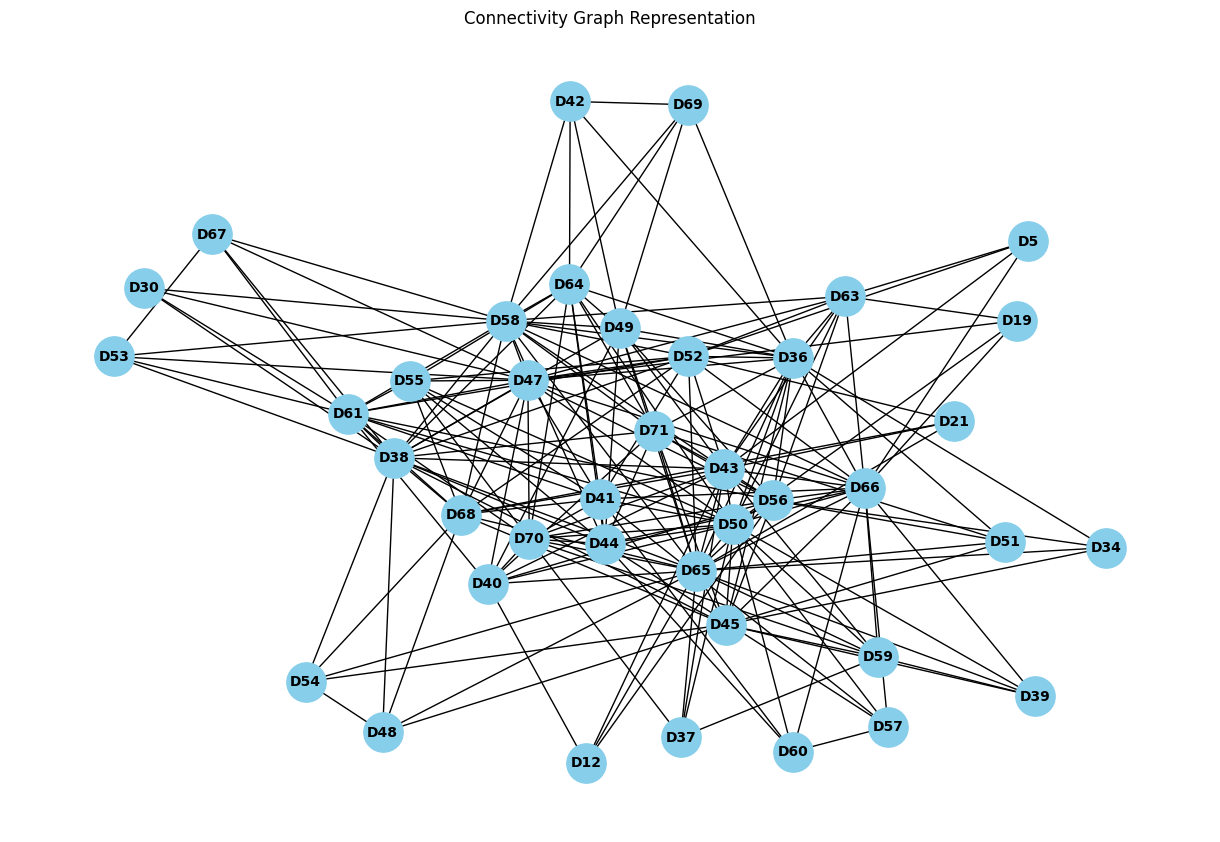

In [ ]:
from hamld.contraction_strategy.hypergraph_to_connectivity import ConnectivityGraph

sub_connectivity_graph = ConnectivityGraph()
sub_connectivity_graph.hypergraph_to_connectivity_graph(sub_priorty_hypergraph, have_logical_observable = False)
sub_connectivity_graph.draw()

我们有两种收缩方式：
1. 按照`sub_priorty_hypergraph.hyperedges`进行收缩，因为这已经进行排好序了。但是，收缩过程中，可能并不是中间状态的最优解，可能在priority设置的比较小的情况下，收缩的代价可能比较大。
处理方法有几种：
* 简单的按照`sub_priorty_hypergraph.hyperedges`进行收缩，其中当前priority下的超边数量不多，或者直接取sub_priorty_hypergraph.hyperedges的topk进行收缩，感觉这个k也不需要很大。
* 进行精准收缩，通过order，得到一个更加好的收缩顺序，因为是精准收缩，所以不需要考虑因为近似导致的误差。但通常需要priority尽可能大，连通图尽可能的简单，但是因为节点的度数都比较大，通常order的效果会不太好。
* 增大priority，就直接不考虑那些低priority的边了。
* 考虑在priority较大的情况下，进行精准的收缩。对于priority较小的情况，进行近似收缩。

2. 我们先收缩一些高priority的边，然后再收缩一些低priority的边。其中，高priority的边，我们可以较为精准的的收缩。低priority的边有很多，但我们可以进行大规模的近似收缩/甚至并行收缩。
* 这里的关键在于，什么算高priority，什么算低priority。因为高priority的边，我们可以较为精准的收缩耗时长，但是数量少。低priority的边，可以近似收缩，数量多，但是收缩速度快。
* 对于并行收缩，可能对于速度的提升不会很快。

## 优先级收缩

在上述中，简单的按照`sub_priorty_hypergraph.hyperedges`进行收缩，取sub_priorty_hypergraph.hyperedges的topk进行收缩的方法较为实现，并且感觉较为靠谱。

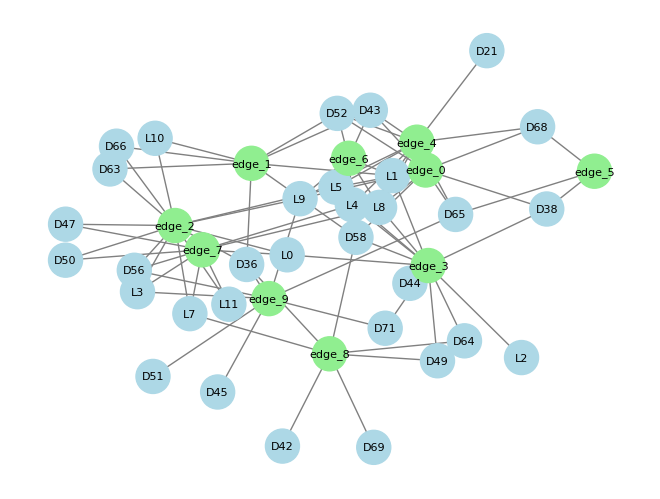

In [12]:
sub_priorty_hypergraph = hypergraph.get_priority_sub_hypergraph(nodes = flipped_detector_set, priority = 3, topk = 10)

sub_priorty_hypergraph.draw_bipartite_graph()

#### Order 性能分析

查看连通图，我们尝试评估一下，精准收缩，是否需要利用到order？
使用order和不使用order

In [13]:
sequence_order = sub_priorty_hypergraph.get_nodes(have_logical_observable=False)

In [ ]:
from hamld.contraction_strategy.hypergraph_to_connectivity import ConnectivityGraph

sub_connectivity_graph = ConnectivityGraph()
sub_connectivity_graph.hypergraph_to_connectivity_graph(sub_priorty_hypergraph, have_logical_observable = False)

In [15]:
# sub_connectivity_graph.draw()

In [ ]:
from hamld.contraction_strategy.mld_order_finder import GreedyMLDOrderFinder, ParallelGreedyMLDOrderFinder

order_finder = GreedyMLDOrderFinder(sub_connectivity_graph)
order = order_finder.find_order()
print(f"order: {order}")
print(f"max_dim:{order_finder.max_prob_dist_dimension}")
print(f"max_dim count:{order_finder.max_prob_dist_dimension_count}")
print(f"max_dim nodes:{order_finder.max_contracted_nodes}")

order: ['D21', 'D68', 'D43', 'D52', 'D63', 'D47', 'D50', 'D66', 'D56', 'D45', 'D51', 'D65', 'D38', 'D44', 'D71', 'D36', 'D42', 'D49', 'D58', 'D64', 'D69']
max_dim:8
max_dim count:1
max_dim nodes:['D63']


In [ ]:
from hamld.contraction_strategy.contraction_tree import ContractionTree

contraction_tree = ContractionTree(order, hypergraph=sub_priorty_hypergraph)
contraction_cost, contraction_width, contraction_cost_each_step = contraction_tree.get_contraction_cost_information()

print(f"收缩的总收缩成本检测器，表示收缩过程的时间: {contraction_cost}")
print(f"收缩过程中的最大检测器宽度，表示内存的最大消耗: {contraction_cost}")
print(f"收缩过程中每步收缩的的检测器成本: {contraction_cost_each_step}")

# 顺序的收缩：

contraction_tree = ContractionTree(sequence_order, hypergraph=sub_priorty_hypergraph)
contraction_cost, contraction_width, contraction_cost_each_step = contraction_tree.get_contraction_cost_information()

print(f"序号顺序收缩的总收缩成本检测器，表示收缩过程的时间: {contraction_cost}")
print(f"序号顺序收缩过程中的最大检测器宽度，表示内存的最大消耗: {contraction_cost}")
print(f"序号顺序收缩过程中每步收缩的的检测器成本: {contraction_cost_each_step}")

收缩的总收缩成本检测器，表示收缩过程的时间: 1135
收缩过程中的最大检测器宽度，表示内存的最大消耗: 1135
收缩过程中每步收缩的的检测器成本: {'D21': 16, 'D68': 32, 'D43': 128, 'D52': 64, 'D63': 256, 'D47': 128, 'D50': 64, 'D66': 32, 'D56': 128, 'D45': 64, 'D51': 32, 'D65': 16, 'D38': 64, 'D44': 32, 'D71': 16, 'D36': 32, 'D42': 16, 'D49': 8, 'D58': 4, 'D64': 2, 'D69': 1}
序号顺序收缩的总收缩成本检测器，表示收缩过程的时间: 655375
序号顺序收缩过程中的最大检测器宽度，表示内存的最大消耗: 655375
序号顺序收缩过程中每步收缩的的检测器成本: {'D21': 16, 'D36': 131072, 'D38': 262144, 'D42': 131072, 'D43': 65536, 'D44': 32768, 'D45': 16384, 'D47': 8192, 'D49': 4096, 'D50': 2048, 'D51': 1024, 'D52': 512, 'D56': 256, 'D58': 128, 'D63': 64, 'D64': 32, 'D65': 16, 'D66': 8, 'D68': 4, 'D69': 2, 'D71': 1}


但本质上其实只有2**10，即可能会超过1024。上述的估计还是存在一点点小问题，是基于连通性来估计的，而不是实际计算的规模。
* 估计存在问题，需要实际测试看看。

假设我们要精准收缩这些超边，理论上用order的方式是最好的。同时代码也不需要大幅度的修改。

#### 超边收缩的具体实现

参考：
* `hamld/src/hamld/contraction_executor/priority_approx_contraction_executor_qldpc.py`
* `hamld/src/hamld/hamld.py`

In [ ]:
import hamld
from hamld.benchmark import generate_qldpc_detector_error_model, LogicalErrorRateBenchmark

nkd = [72, 12, 6]
# nkd = [90, 8, 10]
p = 10
r = 1
noise_model = "si1000" # v5
error_type = "Z"
approximatestrategy = "no_no"
approximate_param = None

related_path = "../data/external/hamld_experiment_data/paper_experiment_bb_codes"
dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=related_path)

decoder = hamld.HAMLD(detector_error_model=dem,
                            order_method='greedy',
                            slice_method='no_slice',
                            use_approx = True,
                            approximatestrategy = approximatestrategy,
                            approximate_param = approximate_param,
                            contraction_code = "qldpc-priority",
                            accuracy = "float64",
                            priority=1,
                            priority_topk=10)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f1bca3641f0>>
Traceback (most recent call last):
  File "/home/normaluser/anaconda3/envs/ck_epmld/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


## Priority TopK精准收缩实验

#### Priority TopK精准收缩方式，单syndrome解码速度测试

In [ ]:
import numpy as np
import time

# syndrome = np.array([False] * dem_r1.num_detectors)
shots = 20
syndrome_length = dem_r1.num_detectors
priority_topk_values = range(5, 61, 5)
# syndrome = np.array([True] + [False] * (dem_r1.num_detectors-1))
syndrome = np.random.rand(shots, syndrome_length) < 0.1
contraction_times = []
for priority_topk in priority_topk_values:
    print("priority_topk:", priority_topk)
    decoder = hamld.HAMLD(detector_error_model=dem,
                                order_method='greedy',
                                slice_method='no_slice',
                                use_approx = True,
                                approximatestrategy = approximatestrategy,
                                approximate_param = approximate_param,
                                contraction_code = "qldpc-priority",
                                accuracy = "float64",
                                priority=1,
                                priority_topk=priority_topk)
    # True的概率小一些
    start = time.time()
    for i in range(shots):
        decoder.decode(syndrome=syndrome[i,:])
    end_time = time.time()
    # print(f"end contraction: {time.time() - start}")
    contraction_times.append((end_time - start)/shots)
print(contraction_times)

priority_topk: 5
priority_topk: 10
priority_topk: 15
priority_topk: 20
priority_topk: 25
priority_topk: 30
priority_topk: 35
priority_topk: 40
priority_topk: 45
priority_topk: 50
priority_topk: 55
priority_topk: 60
[0.0036112427711486816, 0.0037754178047180176, 0.004093897342681885, 0.0042345643043518065, 0.008334267139434814, 0.005504906177520752, 0.008027327060699464, 0.01300281286239624, 0.021617889404296875, 0.3058177947998047, 0.6051783442497254, 1.2850831747055054]


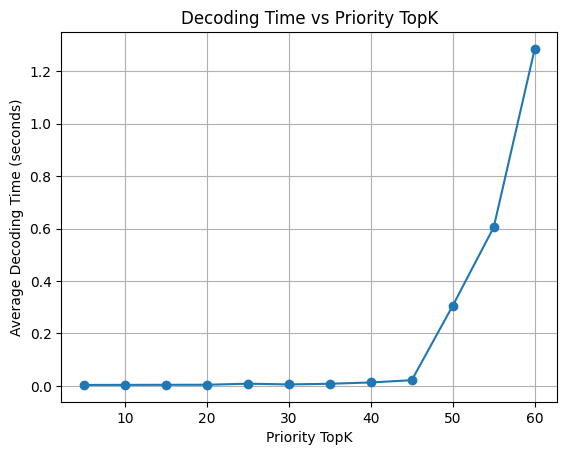

In [ ]:
# 在计算完所有contraction_times后添加以下代码
import matplotlib.pyplot as plt

priority_topk_values = priority_topk_values
plt.plot(priority_topk_values, contraction_times, marker='o')
plt.xlabel('Priority TopK')
plt.ylabel('Average Decoding Time (seconds)')
plt.title('Decoding Time vs Priority TopK')
plt.grid(True)
plt.show()

随着topk的增加，解码速度指数级变大。

#### Priority TopK精准解码的准确率实验

随着topk的增加，解码的准确率变化。

In [ ]:
import numpy as np
import time

nkd = [72, 12, 6]
# nkd = [90, 8, 10]
p = 10
r = 1
noise_model = "si1000" # v5
error_type = "Z"
approximatestrategy = "no_no"
approximate_param = 100

related_path = "../data/external/hamld_experiment_data/paper_experiment_bb_codes"
dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=related_path)

# priority_topk_values = range(4, 21, 2)
priority_topk_values = [10, 20, 30, 40]
logical_error_rate_list = []

for priority_topk in priority_topk_values:
    print("priority_topk:", priority_topk)
    decoder = hamld.HAMLD(detector_error_model=dem,
                                order_method='greedy',
                                slice_method='no_slice',
                                use_approx = True,
                                approximatestrategy = approximatestrategy,
                                approximate_param = approximate_param,
                                contraction_code = "qldpc-priority",
                                accuracy = "float64",
                                priority=1,
                                priority_topk=priority_topk)
    benchmark = LogicalErrorRateBenchmark(
        decoder_function=decoder,
        d=nkd[2],
        nkd=nkd,
        r=r,
        p=p,
        noise_model=noise_model,
        error_type=error_type,
        num_runs=1,
        data_path=related_path,
        code_name="qldpc code"
    )
    logical_error_rate = benchmark.run()[0]
    # print(f"end contraction: {time.time() - start}")
    logical_error_rate_list.append(logical_error_rate)
print(logical_error_rate_list)

priority_topk: 10


2025-04-09 18:28:14,131 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-09 18:28:14,132 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 72)...
2025-04-09 18:28:14,732 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 72) 预处理时间为：0.5998754501342773
2025-04-09 18:28:26,125 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 31370/1000000 mistakes, num_unique_shots is 171984, error rate: 0.031370
2025-04-09 18:28:26,130 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 11.9978 seconds - Error rate: 0.031370
2025-04-09 18:28:26,130 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.031370


priority_topk: 20


2025-04-09 18:28:42,855 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-09 18:28:42,855 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 72)...
2025-04-09 18:28:43,268 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 72) 预处理时间为：0.4118192195892334
2025-04-09 18:28:57,282 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 11922/1000000 mistakes, num_unique_shots is 171984, error rate: 0.011922
2025-04-09 18:28:57,287 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 14.4316 seconds - Error rate: 0.011922
2025-04-09 18:28:57,287 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.011922


priority_topk: 30


2025-04-09 18:29:13,928 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-09 18:29:13,929 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 72)...
2025-04-09 18:29:14,380 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 72) 预处理时间为：0.45076608657836914
2025-04-09 18:30:02,979 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 6184/1000000 mistakes, num_unique_shots is 171984, error rate: 0.006184
2025-04-09 18:30:02,984 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 49.0547 seconds - Error rate: 0.006184
2025-04-09 18:30:02,984 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.006184


priority_topk: 40


2025-04-09 18:30:20,098 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-09 18:30:20,099 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 72)...
2025-04-09 18:30:20,488 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 72) 预处理时间为：0.3889040946960449
2025-04-09 18:32:44,883 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 3622/1000000 mistakes, num_unique_shots is 171984, error rate: 0.003622
2025-04-09 18:32:44,888 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 144.7894 seconds - Error rate: 0.003622
2025-04-09 18:32:44,889 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.003622


[np.float64(0.03137), np.float64(0.011922), np.float64(0.006184), np.float64(0.003622)]


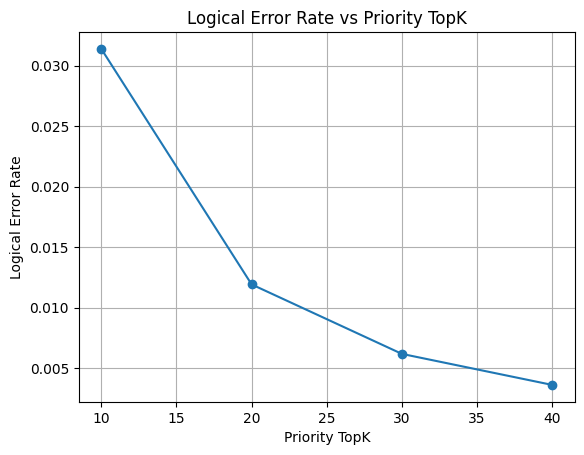

In [ ]:
# 在计算完所有contraction_times后添加以下代码
import matplotlib.pyplot as plt

# priority_topk_values = range(4, 21, 2)
priority_topk_values = [10, 20, 30, 40]
plt.plot(priority_topk_values, logical_error_rate_list, marker='o')
plt.xlabel('Priority TopK')
plt.ylabel('Logical Error Rate')
plt.title('Logical Error Rate vs Priority TopK')
plt.grid(True)
plt.show()

## Priority TopK近似收缩 - order顺序实验

Priority TopK精准收缩方式，单syndrome解码速度测试

In [ ]:
import hamld
from hamld.benchmark import generate_qldpc_detector_error_model, LogicalErrorRateBenchmark

nkd = [72, 12, 6]
# nkd = [90, 8, 10]
p = 10
r = 1
noise_model = "si1000" # v5
error_type = "Z"
approximatestrategy = "hyperedge_topk"
approximate_param = 1000

related_path = "../data/external/hamld_experiment_data/paper_experiment_bb_codes"
dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=related_path)

decoder = hamld.HAMLD(detector_error_model=dem,
                            order_method='greedy',
                            slice_method='no_slice',
                            use_approx = True,
                            approximatestrategy = approximatestrategy,
                            approximate_param = approximate_param,
                            contraction_code = "qldpc-priority",
                            accuracy = "float64",
                            priority=1,
                            priority_topk=10)

#### 速度

In [ ]:
import numpy as np
import time

nkd = [72, 12, 6]
# nkd = [90, 8, 10]
p = 10
r = 1
noise_model = "si1000" # v5
error_type = "Z"
approximatestrategy = "hyperedge_topk"
approximate_param = 1000

related_path = "../data/external/hamld_experiment_data/paper_experiment_bb_codes"
dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=related_path)

shots = 20
syndrome_length = dem.num_detectors
priority_topk_values = range(10, 101, 10)
syndrome = np.random.rand(shots, syndrome_length) < 0.1

contraction_times = []
for priority_topk in priority_topk_values:
    print("priority_topk:", priority_topk)
    decoder = hamld.HAMLD(detector_error_model=dem,
                                order_method='greedy',
                                slice_method='no_slice',
                                use_approx = True,
                                approximatestrategy = approximatestrategy,
                                approximate_param = approximate_param,
                                contraction_code = "qldpc-priority",
                                accuracy = "float64",
                                priority=1,
                                priority_topk=priority_topk)
    # True的概率小一些
    start = time.time()
    for i in range(shots):
        decoder.decode(syndrome=syndrome[i,:])
    end_time = time.time()
    # print(f"end contraction: {time.time() - start}")
    contraction_times.append((end_time - start)/shots)
print(contraction_times)

priority_topk: 10
priority_topk: 20
priority_topk: 30
priority_topk: 40
priority_topk: 50
priority_topk: 60
priority_topk: 70
priority_topk: 80
priority_topk: 90
priority_topk: 100
[0.003871035575866699, 0.00545954704284668, 0.008547377586364747, 0.012160944938659667, 0.013377749919891357, 0.01516876220703125, 0.028806626796722412, 0.050352728366851805, 0.08054533004760742, 0.10636037588119507]


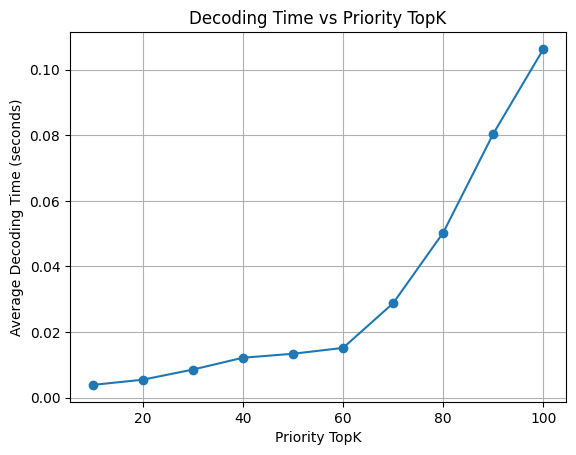

In [ ]:
# 在计算完所有contraction_times后添加以下代码
import matplotlib.pyplot as plt

priority_topk_values = priority_topk_values
plt.plot(priority_topk_values, contraction_times, marker='o')
plt.xlabel('Priority TopK')
plt.ylabel('Average Decoding Time (seconds)')
plt.title('Decoding Time vs Priority TopK')
plt.grid(True)
plt.show()

#### 准确率

In [ ]:
import hamld
from hamld.benchmark import generate_qldpc_detector_error_model, LogicalErrorRateBenchmark

# # nkd = [72, 12, 6]
# nkd = [90, 8, 10]
# p = 10
# r = 1
# noise_model = "si1000" # v5
# error_type = "Z"
# approximatestrategy = "hyperedge_topk"
# approximate_param = 1000

# related_path = "../data/external/hamld_experiment_data/paper_experiment_bb_codes"
# dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=related_path)

In [ ]:
import numpy as np
import time

# nkd = [72, 12, 6]
nkd = [90, 8, 10]
p = 10
r = 1
noise_model = "si1000" # v5
error_type = "Z"
approximatestrategy = "hyperedge_topk"
approximate_param = 1000

related_path = "../data/external/hamld_experiment_data/paper_experiment_bb_codes"
dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=related_path)

priority_topk_values  = range(10, 101, 20)
logical_error_rate_list = []

for priority_topk in priority_topk_values:
    print("priority_topk:", priority_topk)
    decoder = hamld.HAMLD(detector_error_model=dem,
                                order_method='greedy',
                                slice_method='no_slice',
                                use_approx = True,
                                approximatestrategy = approximatestrategy,
                                approximate_param = approximate_param,
                                contraction_code = "qldpc-priority",
                                accuracy = "float64",
                                priority=1,
                                priority_topk=priority_topk)
    benchmark = LogicalErrorRateBenchmark(
        decoder_function=decoder,
        d=nkd[2],
        nkd=nkd,
        r=r,
        p=p,
        noise_model=noise_model,
        error_type=error_type,
        num_runs=1,
        data_path=related_path,
        code_name="qldpc code"
    )
    logical_error_rate = benchmark.run()[0]
    # print(f"end contraction: {time.time() - start}")
    logical_error_rate_list.append(logical_error_rate)
print(logical_error_rate_list)

priority_topk: 10


2025-04-09 19:22:13,001 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-09 19:22:13,002 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 90)...
2025-04-09 19:22:13,624 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 90) 预处理时间为：0.6217405796051025
2025-04-09 19:22:32,051 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 43067/1000000 mistakes, num_unique_shots is 265987, error rate: 0.043067
2025-04-09 19:22:32,056 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 19.0542 seconds - Error rate: 0.043067
2025-04-09 19:22:32,056 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.043067


priority_topk: 30


2025-04-09 19:22:51,336 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-09 19:22:51,336 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 90)...
2025-04-09 19:22:51,842 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 90) 预处理时间为：0.5050125122070312
2025-04-09 19:23:23,881 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 8393/1000000 mistakes, num_unique_shots is 265987, error rate: 0.008393
2025-04-09 19:23:23,886 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 32.5496 seconds - Error rate: 0.008393
2025-04-09 19:23:23,887 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.008393


priority_topk: 50


2025-04-09 19:23:42,845 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-09 19:23:42,845 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 90)...
2025-04-09 19:23:43,346 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 90) 预处理时间为：0.5004522800445557
2025-04-09 19:24:38,464 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 2830/1000000 mistakes, num_unique_shots is 265987, error rate: 0.002830
2025-04-09 19:24:38,468 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 55.6230 seconds - Error rate: 0.002830
2025-04-09 19:24:38,469 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.002830


priority_topk: 70


2025-04-09 19:24:57,630 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-09 19:24:57,631 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 90)...
2025-04-09 19:24:58,069 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 90) 预处理时间为：0.43714427947998047
2025-04-09 19:26:29,296 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 1023/1000000 mistakes, num_unique_shots is 265987, error rate: 0.001023
2025-04-09 19:26:29,301 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 91.6699 seconds - Error rate: 0.001023
2025-04-09 19:26:29,302 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.001023


priority_topk: 90


2025-04-09 19:26:48,026 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-09 19:26:48,027 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 90)...
2025-04-09 19:26:48,508 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 90) 预处理时间为：0.4803481101989746
2025-04-09 19:30:25,809 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 416/1000000 mistakes, num_unique_shots is 265987, error rate: 0.000416
2025-04-09 19:30:25,814 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 217.7863 seconds - Error rate: 0.000416
2025-04-09 19:30:25,814 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.000416


[np.float64(0.043067), np.float64(0.008393), np.float64(0.00283), np.float64(0.001023), np.float64(0.000416)]


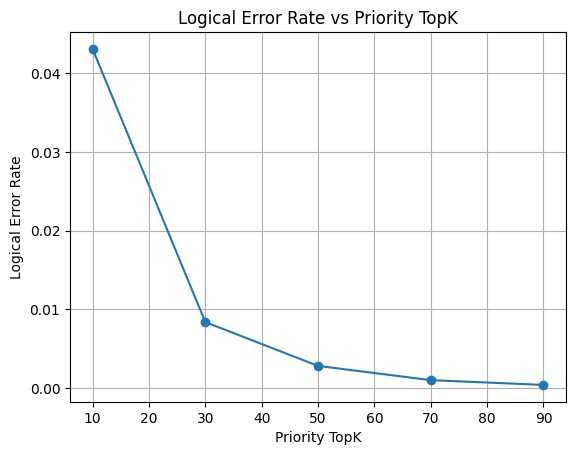

In [ ]:
# 在计算完所有contraction_times后添加以下代码
import matplotlib.pyplot as plt

# priority_topk_values = range(4, 21, 2)
priority_topk_values = range(10, 101, 20)
plt.plot(priority_topk_values, logical_error_rate_list, marker='o')
plt.xlabel('Priority TopK')
plt.ylabel('Logical Error Rate')
plt.title('Logical Error Rate vs Priority TopK')
plt.grid(True)
plt.show()

# 重新定义优先级

In [ ]:
import stim
nkd_72_12_6_r1 = "../data/external/hamld_experiment_data/paper_experiment_bb_codes/Z/nkd_72_12_6_r1/circuit_noisy_si1000_p10.stim"
# nkd_90_8_10_r1 = "../data/external/hamld_experiment_data/paper_experiment_bb_codes/X/nkd_90_8_10_r1/circuit_noisy_si1000_p10.stim"
circuit_noisy_r1 = stim.Circuit.from_file(nkd_72_12_6_r1)
# circuit_noisy_r1 = stim.Circuit.from_file(nkd_90_8_10_r1)
dem = circuit_noisy_r1.detector_error_model(decompose_errors=False, flatten_loops= True)

In [ ]:
from hamld.contraction_strategy.dem_to_hypergraph import DetectorErrorModelHypergraph
hypergraph = DetectorErrorModelHypergraph(detector_error_model=dem, have_logical_observable= True)
nodes = hypergraph.get_nodes()
hyperedges = hypergraph.get_hyperedges()
weights = hypergraph.get_weights()

In [10]:
len(hyperedges)

432

In [3]:
flipped_detector_set = set([f"D{i}" for i in [36, 38, 43, 44, 47, 50, 52, 56, 58, 64, 65, 66, 68]])

In [4]:
for priority in range(-1, len(flipped_detector_set)):
    sub_priorty_hypergraph = hypergraph.get_new_priority_sub_hypergraph(nodes = flipped_detector_set, priority = priority)
    print(f"Priority greater than or equal to: {priority}, hyperedge number is: {len(sub_priorty_hypergraph.hyperedges)}")

Priority greater than or equal to: -1, hyperedge number is: 172
Priority greater than or equal to: 0, hyperedge number is: 77
Priority greater than or equal to: 1, hyperedge number is: 45
Priority greater than or equal to: 2, hyperedge number is: 8
Priority greater than or equal to: 3, hyperedge number is: 7
Priority greater than or equal to: 4, hyperedge number is: 3
Priority greater than or equal to: 5, hyperedge number is: 1
Priority greater than or equal to: 6, hyperedge number is: 1
Priority greater than or equal to: 7, hyperedge number is: 0
Priority greater than or equal to: 8, hyperedge number is: 0
Priority greater than or equal to: 9, hyperedge number is: 0
Priority greater than or equal to: 10, hyperedge number is: 0
Priority greater than or equal to: 11, hyperedge number is: 0
Priority greater than or equal to: 12, hyperedge number is: 0


优先级大于0的边

In [5]:
sub_priorty_hypergraph = hypergraph.get_new_priority_sub_hypergraph(nodes = flipped_detector_set, priority = 0)

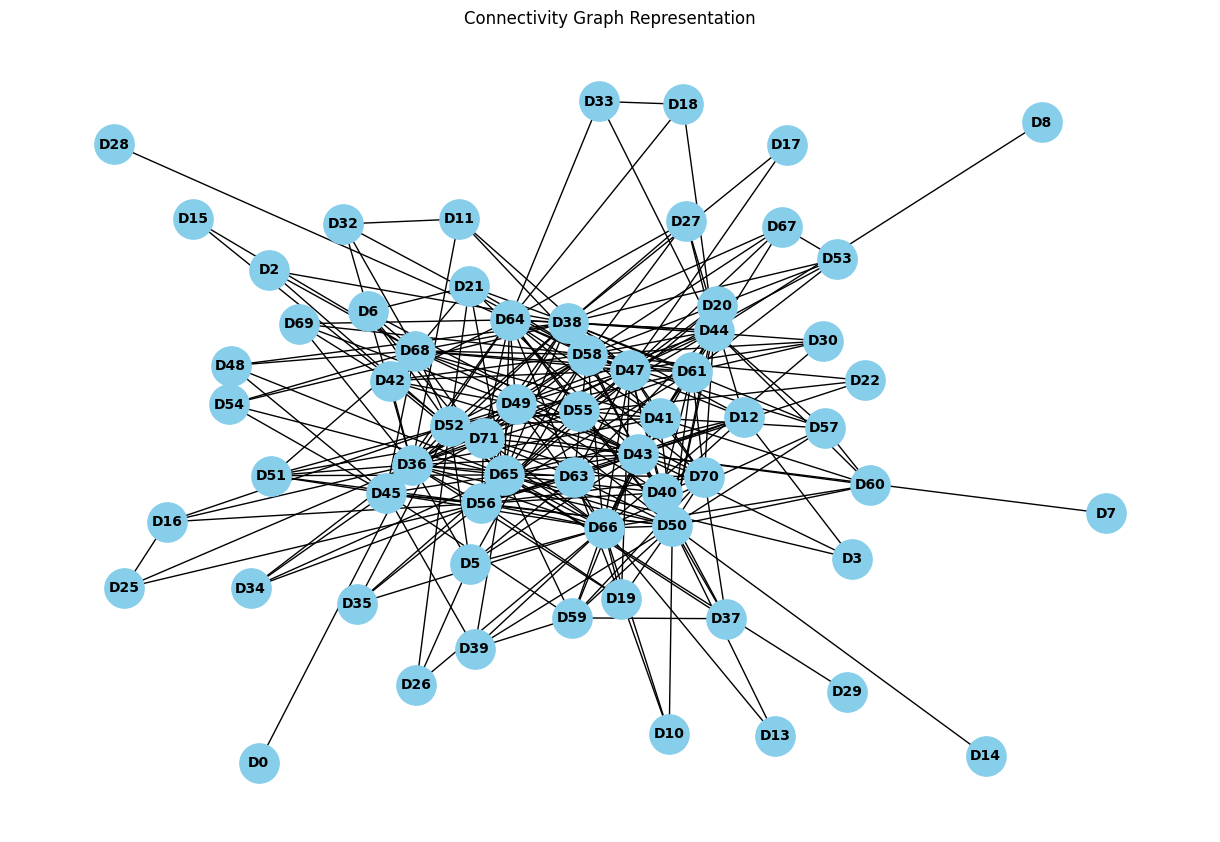

In [ ]:
from hamld.contraction_strategy.hypergraph_to_connectivity import ConnectivityGraph

sub_connectivity_graph = ConnectivityGraph()
sub_connectivity_graph.hypergraph_to_connectivity_graph(sub_priorty_hypergraph, have_logical_observable = False)
sub_connectivity_graph.draw()

## New Priority TopK精准收缩实验

#### New Priority TopK精准收缩方式，单syndrome解码速度测试

In [ ]:
import numpy as np
import time
import hamld

# syndrome = np.array([False] * dem_r1.num_detectors)
shots = 20
syndrome_length = dem.num_detectors
prioritys = [0, 1, 2, 3, 4, 5]
priority_topk = None
# syndrome = np.array([True] + [False] * (dem_r1.num_detectors-1))
syndrome = np.random.rand(shots, syndrome_length) < 0.1

approximatestrategy = "no_no"
approximate_param = None

contraction_times = []
for priority in prioritys:
    print("priority:", priority)
    decoder = hamld.HAMLD(detector_error_model=dem,
                                order_method='greedy',
                                slice_method='no_slice',
                                use_approx = True,
                                approximatestrategy = approximatestrategy,
                                approximate_param = approximate_param,
                                contraction_code = "qldpc-new-priority",
                                accuracy = "float64",
                                priority=priority,
                                priority_topk=priority_topk)
    # True的概率小一些
    start = time.time()
    for i in range(shots):
        decoder.decode(syndrome=syndrome[i,:])
    end_time = time.time()
    # print(f"end contraction: {time.time() - start}")
    contraction_times.append((end_time - start)/shots)
print(contraction_times)

priority: 0
priority: 1
priority: 2
priority: 3
priority: 4
priority: 5
[0.003805553913116455, 0.0035153508186340334, 0.003367304801940918, 0.003312206268310547, 0.003293001651763916, 0.003328979015350342]


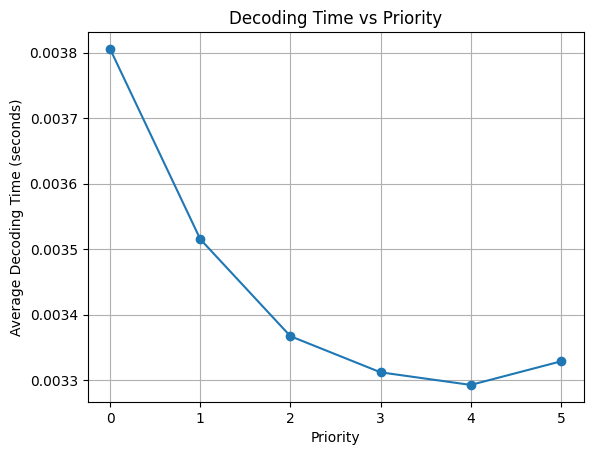

In [8]:
# 在计算完所有contraction_times后添加以下代码
import matplotlib.pyplot as plt

prioritys = prioritys
plt.plot(prioritys, contraction_times, marker='o')
plt.xlabel('Priority')
plt.ylabel('Average Decoding Time (seconds)')
plt.title('Decoding Time vs Priority')
plt.grid(True)
plt.show()

-1需要很久的运行时间。

#### Priority TopK精准解码的准确率实验

In [ ]:
import numpy as np
import time
from hamld.benchmark import generate_qldpc_detector_error_model, LogicalErrorRateBenchmark

nkd = [72, 12, 6]
# nkd = [90, 8, 10]
p = 10
r = 1
noise_model = "si1000" # v5
error_type = "Z"
approximatestrategy = "no_no"
approximate_param = 100

related_path = "../data/external/hamld_experiment_data/paper_experiment_bb_codes"
dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=related_path)

priority_topk_values = [10, 20, 30, 40]
logical_error_rate_list = []

for priority_topk in priority_topk_values:
    print("priority_topk:", priority_topk)
    decoder = hamld.HAMLD(detector_error_model=dem,
                                order_method='greedy',
                                slice_method='no_slice',
                                use_approx = True,
                                approximatestrategy = approximatestrategy,
                                approximate_param = approximate_param,
                                contraction_code = "qldpc-new-priority",
                                accuracy = "float64",
                                priority=0,
                                priority_topk=priority_topk)
    benchmark = LogicalErrorRateBenchmark(
        decoder_function=decoder,
        d=nkd[2],
        nkd=nkd,
        r=r,
        p=p,
        noise_model=noise_model,
        error_type=error_type,
        num_runs=1,
        data_path=related_path,
        code_name="qldpc code"
    )
    logical_error_rate = benchmark.run()[0]
    # print(f"end contraction: {time.time() - start}")
    logical_error_rate_list.append(logical_error_rate)
print(logical_error_rate_list)

priority_topk: 10


2025-04-11 16:39:15,827 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-11 16:39:15,828 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 72)...
2025-04-11 16:39:16,331 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 72) 预处理时间为：0.5025002956390381
2025-04-11 16:39:27,004 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 15306/1000000 mistakes, num_unique_shots is 171984, error rate: 0.015306
2025-04-11 16:39:27,008 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 11.1803 seconds - Error rate: 0.015306
2025-04-11 16:39:27,008 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.015306


priority_topk: 20


2025-04-11 16:39:43,641 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-11 16:39:43,642 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 72)...
2025-04-11 16:39:43,958 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 72) 预处理时间为：0.315767765045166
2025-04-11 16:39:56,457 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 6507/1000000 mistakes, num_unique_shots is 171984, error rate: 0.006507
2025-04-11 16:39:56,461 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 12.8197 seconds - Error rate: 0.006507
2025-04-11 16:39:56,462 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.006507


priority_topk: 30


2025-04-11 16:40:12,845 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-11 16:40:12,845 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 72)...
2025-04-11 16:40:13,157 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 72) 预处理时间为：0.3110489845275879
2025-04-11 16:40:26,999 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 4393/1000000 mistakes, num_unique_shots is 171984, error rate: 0.004393
2025-04-11 16:40:27,004 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 14.1585 seconds - Error rate: 0.004393
2025-04-11 16:40:27,004 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.004393


priority_topk: 40


2025-04-11 16:40:43,609 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-11 16:40:43,610 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 72)...
2025-04-11 16:40:43,975 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 72) 预处理时间为：0.36489272117614746
2025-04-11 16:41:00,088 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 3808/1000000 mistakes, num_unique_shots is 171984, error rate: 0.003808
2025-04-11 16:41:00,093 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 16.4827 seconds - Error rate: 0.003808
2025-04-11 16:41:00,093 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.003808


[np.float64(0.015306), np.float64(0.006507), np.float64(0.004393), np.float64(0.003808)]


相对于之前的[np.float64(0.03137), np.float64(0.011922), np.float64(0.006184), np.float64(0.003622)]，该topk的方法，能够获取更低的逻辑错误率[np.float64(0.015306), np.float64(0.006507), np.float64(0.004393), np.float64(0.003808)]。

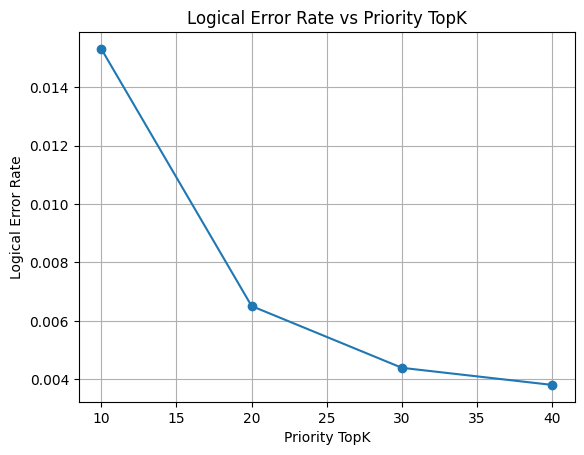

In [10]:
# 在计算完所有contraction_times后添加以下代码
import matplotlib.pyplot as plt

# priority_topk_values = range(4, 21, 2)
priority_topk_values = [10, 20, 30, 40]
plt.plot(priority_topk_values, logical_error_rate_list, marker='o')
plt.xlabel('Priority TopK')
plt.ylabel('Logical Error Rate')
plt.title('Logical Error Rate vs Priority TopK')
plt.grid(True)
plt.show()

## New Priority Tok近似收缩

#### 速度

In [ ]:
import numpy as np
import time

nkd = [72, 12, 6]
# nkd = [90, 8, 10]
p = 10
r = 1
noise_model = "si1000" # v5
error_type = "Z"
approximatestrategy = "hyperedge_topk"
approximate_param = 1000

related_path = "../data/external/hamld_experiment_data/paper_experiment_bb_codes"
dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=related_path)

shots = 20
syndrome_length = dem.num_detectors
priority_topk_values = range(10, 101, 10)
syndrome = np.random.rand(shots, syndrome_length) < 0.1

contraction_times = []
for priority_topk in priority_topk_values:
    print("priority_topk:", priority_topk)
    decoder = hamld.HAMLD(detector_error_model=dem,
                                order_method='greedy',
                                slice_method='no_slice',
                                use_approx = True,
                                approximatestrategy = approximatestrategy,
                                approximate_param = approximate_param,
                                contraction_code = "qldpc-new-priority",
                                accuracy = "float64",
                                priority=0,
                                priority_topk=priority_topk)
    # True的概率小一些
    start = time.time()
    for i in range(shots):
        decoder.decode(syndrome=syndrome[i,:])
    end_time = time.time()
    # print(f"end contraction: {time.time() - start}")
    contraction_times.append((end_time - start)/shots)
print(contraction_times)

priority_topk: 10
priority_topk: 20
priority_topk: 30
priority_topk: 40
priority_topk: 50
priority_topk: 60
priority_topk: 70
priority_topk: 80
priority_topk: 90
priority_topk: 100
[0.0036096930503845214, 0.0037814617156982423, 0.0038382411003112793, 0.003861141204833984, 0.003886210918426514, 0.0038511157035827637, 0.003869163990020752, 0.0038616061210632324, 0.0038695931434631348, 0.0038797140121459963]


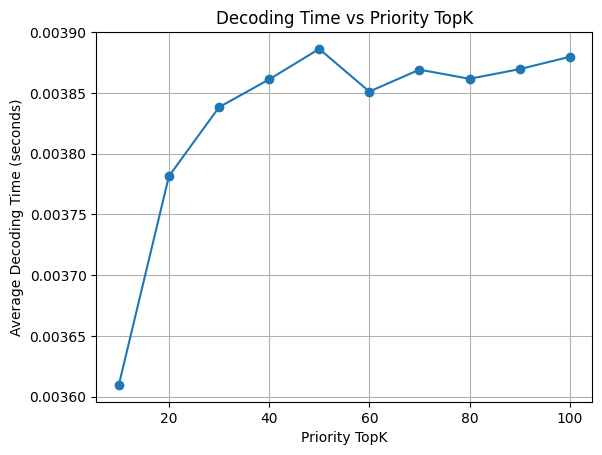

In [14]:
# 在计算完所有contraction_times后添加以下代码
import matplotlib.pyplot as plt

priority_topk_values = priority_topk_values
plt.plot(priority_topk_values, contraction_times, marker='o')
plt.xlabel('Priority TopK')
plt.ylabel('Average Decoding Time (seconds)')
plt.title('Decoding Time vs Priority TopK')
plt.grid(True)
plt.show()

#### 准确率

In [ ]:
import numpy as np
import time

nkd = [72, 12, 6]
# nkd = [90, 8, 10]
p = 10
r = 1
noise_model = "si1000" # v5
error_type = "Z"
approximatestrategy = "hyperedge_topk"
approximate_param = 1000

related_path = "../data/external/hamld_experiment_data/paper_experiment_bb_codes"
dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=related_path)

priority_topk_values  = range(10, 101, 20)
logical_error_rate_list = []

for priority_topk in priority_topk_values:
    print("priority_topk:", priority_topk)
    decoder = hamld.HAMLD(detector_error_model=dem,
                                order_method='greedy',
                                slice_method='no_slice',
                                use_approx = True,
                                approximatestrategy = approximatestrategy,
                                approximate_param = approximate_param,
                                contraction_code = "qldpc-new-priority",
                                accuracy = "float64",
                                priority=0,
                                priority_topk=priority_topk)
    benchmark = LogicalErrorRateBenchmark(
        decoder_function=decoder,
        d=nkd[2],
        nkd=nkd,
        r=r,
        p=p,
        noise_model=noise_model,
        error_type=error_type,
        num_runs=1,
        data_path=related_path,
        code_name="qldpc code"
    )
    logical_error_rate = benchmark.run()[0]
    # print(f"end contraction: {time.time() - start}")
    logical_error_rate_list.append(logical_error_rate)
print(logical_error_rate_list)

priority_topk: 10


2025-04-11 16:47:40,117 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-11 16:47:40,118 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 72)...
2025-04-11 16:47:40,488 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 72) 预处理时间为：0.3690474033355713
2025-04-11 16:47:51,968 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 15306/1000000 mistakes, num_unique_shots is 171984, error rate: 0.015306
2025-04-11 16:47:51,973 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 11.8547 seconds - Error rate: 0.015306
2025-04-11 16:47:51,974 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.015306


priority_topk: 30


2025-04-11 16:48:08,147 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-11 16:48:08,148 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 72)...
2025-04-11 16:48:08,524 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 72) 预处理时间为：0.37563276290893555
2025-04-11 16:48:22,305 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 4393/1000000 mistakes, num_unique_shots is 171984, error rate: 0.004393
2025-04-11 16:48:22,309 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 14.1613 seconds - Error rate: 0.004393
2025-04-11 16:48:22,310 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.004393


priority_topk: 50


2025-04-11 16:48:38,545 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-11 16:48:38,545 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 72)...
2025-04-11 16:48:38,923 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 72) 预处理时间为：0.37697768211364746
2025-04-11 16:48:54,482 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 3608/1000000 mistakes, num_unique_shots is 171984, error rate: 0.003608
2025-04-11 16:48:54,486 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 15.9409 seconds - Error rate: 0.003608
2025-04-11 16:48:54,487 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.003608


priority_topk: 70


2025-04-11 16:49:11,153 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-11 16:49:11,154 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 72)...
2025-04-11 16:49:11,532 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 72) 预处理时间为：0.3778512477874756
2025-04-11 16:49:27,798 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 3524/1000000 mistakes, num_unique_shots is 171984, error rate: 0.003524
2025-04-11 16:49:27,802 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 16.6482 seconds - Error rate: 0.003524
2025-04-11 16:49:27,803 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.003524


priority_topk: 90


2025-04-11 16:49:44,291 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-11 16:49:44,292 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 72)...
2025-04-11 16:49:44,662 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 72) 预处理时间为：0.3694438934326172
2025-04-11 16:50:01,275 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 3506/1000000 mistakes, num_unique_shots is 171984, error rate: 0.003506
2025-04-11 16:50:01,279 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 16.9877 seconds - Error rate: 0.003506
2025-04-11 16:50:01,280 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.003506


[np.float64(0.015306), np.float64(0.004393), np.float64(0.003608), np.float64(0.003524), np.float64(0.003506)]


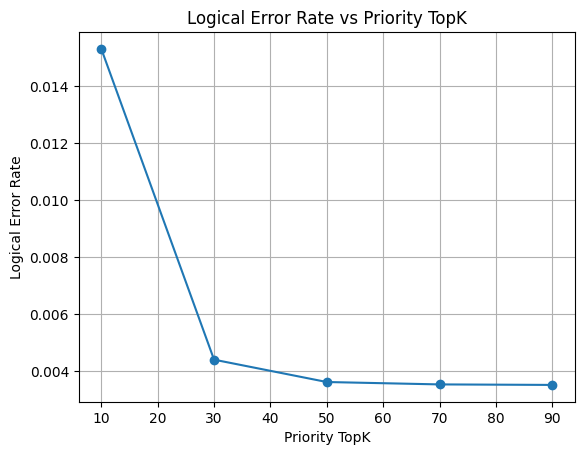

In [12]:
# 在计算完所有contraction_times后添加以下代码
import matplotlib.pyplot as plt

# priority_topk_values = range(4, 21, 2)
priority_topk_values = range(10, 101, 20)
plt.plot(priority_topk_values, logical_error_rate_list, marker='o')
plt.xlabel('Priority TopK')
plt.ylabel('Logical Error Rate')
plt.title('Logical Error Rate vs Priority TopK')
plt.grid(True)
plt.show()